<a href="https://colab.research.google.com/github/Sophie1218/HMTK_DS102.L11.CNCL/blob/main/Code_RunModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Install libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings 
  
warnings.filterwarnings(action = 'ignore') 

In [3]:
import os
import time
import string
import random
import wordcloud
import seaborn as sns
import pandas as pd
import numpy as np
import numpy as np
import matplotlib
import regex as re
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm_notebook
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [4]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Bert_Complaint')

In [5]:
!nvidia-smi

Mon Dec 14 01:24:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!pip install transformers

  Using cached https://files.pythonhosted.org/packages/0f/1c/e789a8b12e28be5bc1ce2156cf87cb522b379be9cadc7ad8091a4cc107c4/tokenizers-0.9.4-cp36-cp36m-manylinux2010_x86_64.whl
ERROR: transformers-phobert 3.1.2 has requirement tokenizers==0.8.1.rc2, but you'll have tokenizers 0.9.4 which is incompatible.
  Found existing installation: tokenizers 0.8.1rc2
    Uninstalling tokenizers-0.8.1rc2:
      Successfully uninstalled tokenizers-0.8.1rc2


In [7]:
!pip install fastBPE
!pip install fairseq

In [8]:
!pip install vncorenlp

In [9]:
!pip install transformers-phobert

  Using cached https://files.pythonhosted.org/packages/80/83/8b9fccb9e48eeb575ee19179e2bdde0ee9a1904f97de5f02d19016b8804f/tokenizers-0.8.1rc2-cp36-cp36m-manylinux1_x86_64.whl
ERROR: transformers 4.0.1 has requirement tokenizers==0.9.4, but you'll have tokenizers 0.8.1rc2 which is incompatible.
  Found existing installation: tokenizers 0.9.4
    Uninstalling tokenizers-0.9.4:
      Successfully uninstalled tokenizers-0.9.4


In [10]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("/content/drive/MyDrive/Colab Notebooks/VnCoreNLP-master/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

In [11]:
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="/content/drive/MyDrive/Colab Notebooks/PhoBERT_base_transformers/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("/content/drive/MyDrive/Colab Notebooks/PhoBERT_base_transformers/PhoBERT_base_transformers/dict.txt")

In [12]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Bert_Complaint/Dataset_DL.csv')
df.head()

,ID,Comment,Label,Domain
0,1117661425258766_1117711878587054,Tắt Ai tự động nhận diện ảnh kiểu gì ak,0,Điện thoại
1,1117661425258766_1117711881920387,So sánh với Nokia 8.1,0,Điện thoại
2,1117661425258766_1117712271920348,A51 vs reno 2F máy nào tốt hơn a,0,Điện thoại
3,1117661425258766_1117712698586972,Giật nhỉ :)),1,Điện thoại
4,1117661425258766_1117712938586948,"Mới toang con 7plus,hôm qua ra làm luôn con nà...",1,Điện thoại



# Preprocess data

In [13]:
uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"
 
def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic
dicchar = loaddicchar()

def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]
bang_ky_tu_dau = ['', 'f', 's', 'r', 'x', 'j']

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

def chuan_hoa_dau_tu_tieng_viet(word):
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            # for index2 in nguyen_am_index:
            #     if index2 != index:
            #         x, y = nguyen_am_to_ids[chars[index]]
            #         chars[index2] = bang_nguyen_am[x][0]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            # chars[nguyen_am_index[1]] = bang_nguyen_am[x][0]
        else:
            # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
        # chars[nguyen_am_index[0]] = bang_nguyen_am[x][0]
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
        # x, y = nguyen_am_to_ids[chars[nguyen_am_index[2]]]
        # chars[nguyen_am_index[2]] = bang_nguyen_am[x][0]
    return ''.join(chars)


def is_valid_vietnam_word(word):
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True


def chuan_hoa_dau_cau_tieng_viet(sentence):
    """
        Chuyển câu tiếng việt về chuẩn gõ dấu kiểu cũ.
        :param sentence:
        :return:
        """
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = chuan_hoa_dau_tu_tieng_viet(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

def remove_html(txt):
    return re.sub(r'<[^>]*>', '', txt)

In [14]:
def text_preprocess(document):
    # delete html code
    document = remove_html(document)
    # standardized unicode
    document = convert_unicode(document)
    # standardized typing Vietnamese accents
    document = chuan_hoa_dau_cau_tieng_viet(document)
    # lower
    document = document.lower()
    # delete unnecessary characters 
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
    # delete extra spaces
    document = re.sub(r'\s+', ' ', document).strip()
    return document

In [15]:
df["Comment"] = df["Comment"].apply(text_preprocess)

In [16]:

abbr_dict={'k':'không','t':'tôi','fb':'facebook','mess':'messenger','mn':'mọi người','gr':'group','dc':'được','ko':'không','mng':'mọi người','cty':'công ty','1':'một','ngta':'người ta','ng':'người','oki':'ok','thg':'thường','vn':'việt nam','tq':'trung quốc','insta':'instagram','connect':'kết nối','user':'người dùng','h':'giờ','nt':'nhắn tin','dth':'dễ thương','đt':'điện thoại','qc':'quảng cáo','pr':'quảng cáo','ae':'anh em','trung':'trung quốc','tk':'tài khoản','mị':'tôi','chăn rau':'gạ gẫm','ny':'người yêu','lq':'game','wa':'quá','ak':'á','í':'ý','ms':'mới','ip':'iphone','apple':'iphone','kh':'không','cùi':'tệ','dg':'đang','ms':'mới','vs':'với','lm':'làm','bik':'biết','tàu':'trung quốc','tn':'tin nhắn','comment':'bình luận','ng':'người','app':'ứng dụng','u.d':'ứng dụng','j':'gì','mk':'tôi','inb':'nhắn tin','nick':'tài khoản','cmt':'bình luận','update':'nâng cấp','hk':'hông','hoy':'thôi','xh':'xã hội','ntn':'như thế nào',
'gr':'group','mxh':'mạng xã hội','đc':'được','ko':'không','fb':'facebook','zl':'zalo','tw':'twitter','tele':'telegram','t':'tôi','mng':'mọi người','ng':'người','nma':'nhưng mà','cty':'công ty','vidcall':'video call','acc':'account','tumblr':'tumbler',
'mn':'mọi người','ngta':'người ta','hong':'không','vn':'Việt Nam','vl':'quá trời','cm':'chúng mày','tq':'Trung Quốc','thg':'thường','face':'facebook','hs':'Hoàng Sa','ts':'Trường Sa','vn':'Việt Nam','tq':'Trung Quốc','nn':'nước ngoài','dn':'doanh nghiệp',
'fb':'facebook','bt':'biết','vs':'với','pr':'quảng cáo','dth':'dễ thương','sx':'sản xuất','vn':'Việt Nam','pỏn':'porn','ig':'instagram','klq':'không liên quan',
'mobi':'mobile','ae':'anh em','ny':'người yêu','nhứt':'nhất','trc':'trước','zm':'zing me','n':'nhiều','mess':'messenger','tk':'tài khoản','r':'rồi','mị':'mình','ib':'inbox','nf':'new feed','nhug':'nhưng','sđ':'sử dụng','tung của':'Trung Quốc','mer':'mơ','cmt':'comment','j':'gì','4rum':'forum','nyc':'người yêu cũ','đc':'được','dùg':'dùng','dùngg':'dùng','trường cđ':'trường cao đẳng','cae':'cả anh em','Ms':'microsoft',
'nhìu':'nhiều','sv':'sinh viên','hwa':'hôm qua','ae':'anh em','save':'lưu','bank':'ngân hàng','tgioi':'thế giới','méo':'không','ndung':'nội dung','e':'em','áh':'á',
'nf':'new feed','xh':'xã hội','ak':'á','trc':'trước','đb':'đầu bùi','ad':'admin','k':'không','t':'tôi','fb':'facebook','mess':'messenger','mn':'mọi người','gr':'group','dc':'được','ko':'không','mng':'mọi người','cty':'công ty','1':'một','ngta':'người ta','ng':'người','oki':'ok','thg':'thường','vn':'việt nam','tq':'trung quốc','die':'chết','insta':'instagram','connect':'kết nối','user':'người dùng','h':'giờ','nt':'nhắn tin','dth':'dễ thương','đt':'điện thoại','qc':'quảng cáo','pr':'quảng cáo','ae':'anh em','trung':'trung quốc','tk':'tài khoản','mị':'tôi','chăn rau':'gạ gẫm','ny':'người yêu','lq':'game','wa':'quá','ak':'á','í':'ý','ms':'mới','ip':'iphone','apple':'iphone','kh':'không','cùi':'tệ','dg':'đang','ms':'mới','vs':'với','lm':'làm','bik':'biết','tàu':'trung quốc',
'tn':'tin nhắn','comment':'bình luận','ng':'người','app':'ứng dụng','u.d':'ứng dụng','j':'gì','mk':'tôi','inb':'nhắn tin','nick':'tài khoản','cmt':'bình luận','update':'nâng cấp','hk':'hông','hoy':'thôi','xh':'xã hội','ntn':'như thế nào','b':'bạn','sp':'sản phẩm','oki':'ok','dùg':'dùng','hk':'không','nc': 'nước','í': 'ý','e':'em','srm': 'sữa rửa mặt','rv': 'review','kcn': 'kem chống nắng','ttrang': 'tẩy trang','bn':'bao nhiêu','r': 'rồi','ah':'ạ','m': 'mình','oke': 'ok','zới': 'với','rw': 'review','klq': 'không liên quan','sr': 'serum','mp': 'mỹ phẩm','cx':'cũng','cj': 'chị','c':'chị','ttbc': 'tẩy tế bào chết','ng':'người','v': 'vậy','ce': 'chị em','hok': 'không','lquan':'liên quan','nèe': 'nè','bạnn': 'bạn','sis': 'chị','pk': 'biết','sg':'sài gòn','ntn': 'như thế này','bit': 'biết','tnao': 'thế nào','okeee':'ok','ơu': 'ơi','xl': 'xin lỗi','bh': 'bây giờ','hh': 'hỗn hợp','cũngg': 'cũng','hjx': 'hic','tr': 'trời','ln': 'luôn','od': 'đặt hàng','thik': 'thích','ncl': 'nói chung là','ơii': 'ơi','n': 'nó','N':'nó','nhiêud': 'nhiều','ek': 'em','Mội': 'mọi','mjnh': 'mình','bth': 'bình thường','gù': 'gì','rww': 'bình luận','lq': 'liên quan','oie': 'ơi','okela': 'ok','mem': 'bạn','siu':'siêu','Vtm tree': 'nhãn_hiệu','gth': 'giới thiệu','yt': 'youtube','th': 'trường hợp','nhưg': 'nhưng','mrm': 'sữa rửa mặt','ci': 'chị','bt': 'biết','pai': 'phải','ngta': 'người ta','m.n': 'mọi người','ms': 'mới','cx': 'cũng','thíc':'thích','dg': 'đang','tt': 'tẩy trang','kb': 'không biết','hq':'Hàn Quốc','sd':'sử dụng','nc':'nước','lcl':'lỗ chân lông','b':'bạn','r':'rồi','mh':'mình','xog':'xong','nh':'nhiều','c':'chị','r':'rồi','m':'mình','auth':'chính hãng','ah':'ạ','sp':'sản phẩm','bn':'bạn','xg':'xong','mk':'mình','bth':'bình thường','or':'hoặc','m.n':'mọi người','v':'vậy','mrm':'sữa rửa mặt','sr':'serum','ngkhac':'người khác','vsinh':'vệ sinh','mn':'mặt nạ','kh':'không','lun':'luôn','hiu hiu':'khóc','bio':'bio','TO':'The Ordinary','td':'tẩy da','nek':'nè','mìk':'mình','ạk':'ạ','mog':'mong','lsao':'là sao','s':'sao','ak':'á','siu siu':'siêu siêu','cx':'cũng','kp':'không phải','bt':'bình thường','hhtd':'hỗn hợp thiên dầu','ord':'đặt hàng','đc':'được','ợ':'ạ','kp':'không phải','đk':'được','nta':'người ta','hời':'trời ơi','td':'tác dụng','sr':'xin lỗi','ui':'ôi','tt':'tẩy trang','oi':'ơi','kb':'không biết','z':'vậy','sis':'chị gái','nvay':'như vậy','vd':'ví dụ','hsinh':'hi sinh','mh':'mình','eee':'ê','a':'anh','hông':'không','bh':'bao giờ','qq':'quần què','gg':'google','mọi ng':'mọi người','ni':'này','hq':'hôm qua','òy':'rồi','rcm':'tư vấn','fai':'phải','vđ':'ví dụ','đg':'đang','ối':'trời ơi','èo':'eo ôi','cskh':'chăm sóc khách hàng','f':'phải','nầy':'này','nx':'nhận xét','zô':'vô','TG':'thế giới','ui':'ơi','hhtk':'hỗn hợp thiên khô','oki':'ok','ytb':'youtuber','ún':'uống','hs':'học sinh','sv':'sinh viên','nc':'nói chung','ng':'người','400k':'400 nghìn','tbc':'tế bào chết','vứiiii':'với','mđ':'mấy đứa','ts':'tới','bn':'bao nhiêu','tờ':'trộn','zs':'với','ch':'chưa','é':'á','okies':'ok','tphan':'thành phần','coa':'có','hk':'không','ttbc':'tẩy tế bào chết','dk':'được','nhma':'nhưng mà','mọe':'mẹ','rì':'nhận xét','dug':'đúng','ck':'chồng','tv':'tư vấn','tg':'thời gian','oy':'ơi','cd':'công dụng','bn':'bạn', 'bum':'bướm','búm':'bướm','nhg':'nhưng','hok':'không','ks':'không sao','qtrong':'quan trọng','tgian':'thời gian','tr':'trời','tnao':'thế nào','hôg':'không','kbt':'không biết sao','body':'cơ thể','review':'bình luận','toner':'nước_dưỡng','naruko':'nhãn_hiệu','saem':'nhãn_hiệu','aztec':'nhãn_hiệu','lotion':'sữa_dưỡng','khoing':'không','skincare':'sp_dưỡng_da','serum':'tinh chất','melano':'nhãn_hiệu','simple':'nhãn_hiệu','laroche':'nhãn_hiệu','senka':'nhãn_hiệu','acnes':'nhãn_hiệu','cerave':'nhãn_hiệu','silicon':'chất hại','liti':'li ti','từg':'từng','fake':'giả','makup':'trang điểm'
}
def find_replace(list_token, dictionary):
    for idx, item in enumerate(list_token): 
        if item in dictionary.keys():
            list_token[idx] = dictionary[item]            
    return list_token 


In [17]:
for i in range(len(df)):
    df["Comment"][i] = find_replace(df["Comment"][i].split(' '), abbr_dict)
#convert to string
for i in range(len(df)):
   df["Comment"][i]= ' '.join(df["Comment"][i])
comments = df["Comment"]

In [18]:
for i in range(len(df)):
  df["Comment"][i] = rdrsegmenter.tokenize(df["Comment"][i])
  df["Comment"][i] = ' '.join([' '.join(x) for x in df["Comment"][i]])


In [19]:
# Find the maximum length
length = []
for i in range(len(df)):
  length.append(len(df["Comment"][i]))

2020-12-14 01:25:10 | INFO | numexpr.utils | NumExpr defaulting to 4 threads.


Text(0.5, 0, 'Token count')

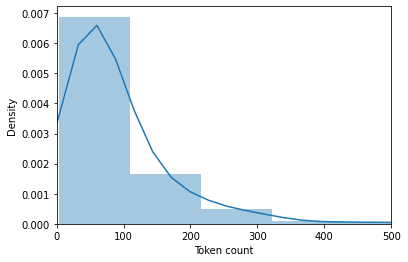

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(length)
plt.xlim([0, 500]);
plt.xlabel('Token count')
 

# Split Train Set và Test Set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df["Comment"], df['Label'], test_size=0.2,random_state=42)

In [22]:
test = X_test.tolist()
print('Train:\n',y_train.value_counts(normalize=False))
print('Test:\n',y_test.value_counts(normalize=False))

Train:
 0    1060
1     872
Name: Label, dtype: int64
Test:
 0    262
1    221
Name: Label, dtype: int64


# Machine Learning

Vector hóa dữ liệu: TF-IDF

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_cv = cv.fit_transform(X_train)
print(X_cv.shape[1])

3922


In [24]:
tfidf = TfidfVectorizer(max_features= 3900)
X_train_tfidf = tfidf.fit_transform(X_train.astype('U')).toarray()
X_test_tfidf = tfidf.transform(X_test.astype('U')).toarray()

In [25]:
X_train_tfidf.shape

(1932, 3900)

In [26]:
# Standardize data
sc = StandardScaler()
X_train_tfidf = sc.fit_transform(X_train_tfidf)
X_test_tfidf = sc.transform(X_test_tfidf)

LR: 0.713035 (0.022724)
KNN: 0.598285 (0.036204)
DTree: 0.681863 (0.028990)
NB: 0.647142 (0.023572)
SVM: 0.706924 (0.027245)
RF: 0.741755 (0.020048)


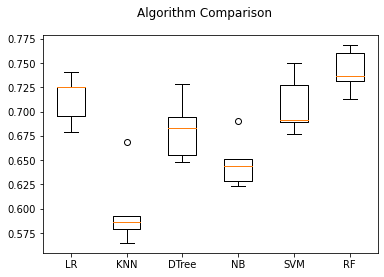

CPU times: user 1min 43s, sys: 1.79 s, total: 1min 45s
Wall time: 1min 41s


In [27]:
%%time
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTree', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF',RandomForestClassifier()))

results = []
names = []
scoring='f1_macro'
for name, model in models:
	kfold = model_selection.KFold(n_splits=5)
	cv_results = model_selection.cross_val_score(model, X_train_tfidf, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
  
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

In [28]:
%%time
#Tuning hyparameters of Random Forest
from sklearn.model_selection import GridSearchCV

grid_param = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

rf_grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_param, cv= 5,scoring='f1_macro')

rf_grid.fit(X_train_tfidf, y_train)

print(rf_grid.best_params_)
print(rf_grid.best_score_)


{'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 1000}
0.7544629394175344
CPU times: user 17min 26s, sys: 884 ms, total: 17min 27s
Wall time: 17min 27s


In [29]:
%%time
#Tuning hyparameters of Logistic Regression
grid_param = {"C": [0.001,0.01,0.1,1,10],
"penalty" : ['l1', 'l2']
}
lr_grid = GridSearchCV(estimator=LogisticRegression(), param_grid=grid_param, cv= 5,scoring='f1_macro')

lr_grid.fit(X_train_tfidf, y_train)

print(lr_grid.best_params_)
print(lr_grid.best_score_)

{'C': 0.01, 'penalty': 'l2'}
0.7432500811479098
CPU times: user 15.2 s, sys: 6.97 s, total: 22.1 s
Wall time: 5.68 s


In [30]:
%%time
#Tuning hyparameters of Decison Tree

grid_param = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
             'min_samples_split': [2, 3]}

DT_grid = GridSearchCV(estimator=DecisionTreeClassifier(), 
                     param_grid=grid_param, 
                     cv=5, 
                     scoring='f1_macro')

DT_grid.fit(X_train_tfidf, y_train);

print(DT_grid.best_params_)

print(DT_grid.best_score_)

{'criterion': 'gini', 'max_depth': 6, 'min_samples_split': 2}
0.6000249671134593
CPU times: user 29.9 s, sys: 293 ms, total: 30.2 s
Wall time: 29.9 s


In [31]:
%%time
#Tuning hyparameters of SVM
grid_param = {'C': [0.0001,0.01,0.1,1,10,100,1000],
             'gamma': [1, 0.1, 0.001, 0.0001],
             'kernel': ['linear', 'rbf']}

SVM_grid = GridSearchCV(estimator=SVC(), 
                     param_grid=grid_param, 
                     cv=5, 
                     scoring='f1_macro')

SVM_grid.fit(X_train_tfidf, y_train);

print(SVM_grid.best_params_)

print(SVM_grid.best_score_)

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.7473330560935201
CPU times: user 1h 43s, sys: 199 ms, total: 1h 43s
Wall time: 1h 43s


In [32]:
%%time
# Final Results in Test Set
models = []
models.append(SVM_grid.best_estimator_)
models.append(rf_grid.best_estimator_)
models.append(lr_grid.best_estimator_)
models.append(DT_grid.best_estimator_)

for model in models:
  y_pred = model.predict(X_test_tfidf)
  print(classification_report(y_test, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.8027    0.6832    0.7381       262
           1     0.6808    0.8009    0.7360       221

    accuracy                         0.7371       483
   macro avg     0.7417    0.7421    0.7371       483
weighted avg     0.7469    0.7371    0.7371       483

              precision    recall  f1-score   support

           0     0.7500    0.7901    0.7695       262
           1     0.7343    0.6878    0.7103       221

    accuracy                         0.7433       483
   macro avg     0.7421    0.7389    0.7399       483
weighted avg     0.7428    0.7433    0.7424       483

              precision    recall  f1-score   support

           0     0.7913    0.7672    0.7791       262
           1     0.7336    0.7602    0.7467       221

    accuracy                         0.7640       483
   macro avg     0.7625    0.7637    0.7629       483
weighted avg     0.7649    0.7640    0.7642       483

              preci

# Bert

In [33]:

MAX_LEN = 125

train_ids = []
for sent in X_train:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    train_ids.append(encoded_sent)

test_ids = []
for sent in X_test:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    test_ids.append(encoded_sent)
    
train_ids = pad_sequences(train_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_ids = pad_sequences(test_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

In [34]:
train_masks = []
for sent in train_ids:
    mask = [int(token_id > 0) for token_id in sent]
    train_masks.append(mask)

test_masks = []
for sent in test_ids:
    mask = [int(token_id > 0) for token_id in sent]

    test_masks.append(mask)

In [35]:
train_inputs = torch.tensor(train_ids)
test_inputs = torch.tensor(test_ids)
y_train = torch.tensor((y_train.tolist()).copy())
y_test = torch.tensor((y_test.tolist()).copy())
train_masks = torch.tensor(train_masks)
test_masks = torch.tensor(test_masks)

train_data = TensorDataset(train_inputs, train_masks, y_train)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

test_data = TensorDataset(test_inputs, test_masks, y_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

In [36]:
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW

config = RobertaConfig.from_pretrained(
    "/content/drive/MyDrive/Colab Notebooks/PhoBERT_base_transformers/PhoBERT_base_transformers/config.json", from_tf=False, num_labels = 2, output_hidden_states=False,
)
BERT = RobertaForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/Colab Notebooks/PhoBERT_base_transformers/PhoBERT_base_transformers/model.bin",
    config=config
)

Some weights of the model checkpoint at /content/drive/MyDrive/Colab Notebooks/PhoBERT_base_transformers/PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/Col

In [37]:
BERT.cuda()
print('Done')

Done


In [38]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    F1_score = f1_score(pred_flat, labels_flat, average='macro')
    
    return accuracy_score(pred_flat, labels_flat), F1_score

In [39]:
device = 'cuda'
epochs = 5

param_optimizer = list(BERT.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)


for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0
    BERT.train()
    train_accuracy = 0
    nb_train_steps = 0
    train_f1 = 0
    
    for step, batch in tqdm_notebook(enumerate(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        BERT.zero_grad()
        outputs = BERT(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask, 
            labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy, tmp_train_f1 = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        train_f1 += tmp_train_f1
        nb_train_steps += 1
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(BERT.parameters(), 1.0)
        optimizer.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    print(" Accuracy: {0:.4f}".format(train_accuracy/nb_train_steps))
    print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
    print(" Average training loss: {0:.4f}".format(avg_train_loss))

    print("Running Test...")
    BERT.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0
    y_pred = []
    for batch in tqdm_notebook(test_dataloader):

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = BERT(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask)
            logits = outputs[0]
            
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()
            for i in pred_flat:
              y_pred.append(i)

            tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            nb_eval_steps += 1
    print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
print("Training complete!")

======== Epoch 1 / 5 ========
Training...



 Accuracy: 0.6964
 F1 score: 0.6558
 Average training loss: 0.5616
Running Test...



 Accuracy: 0.8203
 F1 score: 0.8128
======== Epoch 2 / 5 ========
Training...



 Accuracy: 0.8330
 F1 score: 0.8243
 Average training loss: 0.3699
Running Test...



 Accuracy: 0.8398
 F1 score: 0.8343
======== Epoch 3 / 5 ========
Training...



 Accuracy: 0.9011
 F1 score: 0.8951
 Average training loss: 0.2506
Running Test...



 Accuracy: 0.8379
 F1 score: 0.8341
======== Epoch 4 / 5 ========
Training...



 Accuracy: 0.9416
 F1 score: 0.9388
 Average training loss: 0.1728
Running Test...



 Accuracy: 0.8555
 F1 score: 0.8529
======== Epoch 5 / 5 ========
Training...



 Accuracy: 0.9442
 F1 score: 0.9418
 Average training loss: 0.1477
Running Test...



 Accuracy: 0.8574
 F1 score: 0.8533
Training complete!


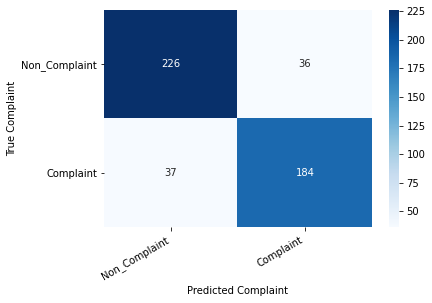

In [40]:
from sklearn.metrics import confusion_matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Complaint')
  plt.xlabel('Predicted Complaint');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['Non_Complaint','Complaint'], columns=['Non_Complaint','Complaint'])

show_confusion_matrix(df_cm)

In [41]:
#  print('Câu bình luận không phàn nàn bị nhận nhầm:')
index_Non_False = []
for i in range(len(y_test)):
  if (y_test[i] == 0) and (y_pred[i] == 1):
    index_Non_False.append(i)
for i in index_Non_False:
  print(test[i])

đang dài mới biết được trụ được một 2 trận thì không thể_hiện được
vừa định đặt mua mà nghe nói cũng sợ sợ mình da_dầu mụn ẩn
zalo nó chỉ là ứng_dụng nhắn_tin này_nọ chứ chưa được tính là mạng xã_hội mà chưa kể nó bảo_mật được tin nhắn thông_tin tốt thì có gì đâu đã muốn cắm_sừng thì shopee ứng_dụng ngân_hàng nó còn cắm được nói gì zalo
hic mấy năm nay mình toàn nhãn _ hiệu thấy cũng khá ổn cơ_mà hóng thấy bảo có cồn vậy không biết mình nên dùng loại nào ạ mong cao_nhân nào chỉ giúp mình với
bạn nên đổi sữa rửa mặt mình nghĩ do sữa rửa mặt kg hợp á
mới đặt mua hàng chưa về mà các chị làm em hoang_mang quá
sau 15phut gánh team mà pin tụt có 4 quá ngầu
kiềm dầu tốt lắm bạn ơi không có lên mụn không bí đâu nhớ tẩy_trang kĩ nha nâng tone ban_đầu sẽ thấy trắng quá mức ý nhưng đừng lo khi mà nó xuống tone ý nó sẽ tự_nhiên gần với màu_da thật của mình luôn
máy mình lla để qua đêm không sụt tí nào
cũng số tiền đó có_thể mua được chiếc iphone có suất xứ tại châu_âu nhưng đa_phần mọi người mua i

In [42]:
#print('Câu bình luận phàn nàn bị nhận nhầm:')
index_Com_False = []
for i in range(len(y_test)):
  if (y_test[i] == 1) and (y_pred[i] == 0):
    index_Com_False.append(i)
for i in index_Com_False:
  print(test[i])

vừa đăng về lịch_sử buổi sáng buổi chiều khoá hoàn_toàn chức_năng hiểu mục_đích rồi chứ
ok lam nhung toi rat mong cac anh ra phan bạn moi hon sang tao hon va ok hon khac phuc loi va khieu nai ve phan bạn cu von da loi_thoi nay chi su dung một so diwn thoai con một so khac không su dung duoc neu dung luong phien ban sao ich hon thi cang duoc danh_gia cao hon rat mong ben phia cac nha sang bài đánh_giá đầy đuỏk lam nhung toi rat mong cac anh ra phan bạn moi hon sang tao hon va ok hon khac phuc loi va khieu nai ve phan bạn cu von da loi_thoi nay chi su dung một so diwn thoai con một so khac không su dung duoc neu dung luong phien ban sao ich hon thi cang duoc danh_gia cao hon rat mong ben phia cac nha sang tao nhin thay y kien cua toi rat cam on
da mình cũng dầu mụn dùng em này mặt như chảo dầu luôn
nếu bạn thích tăng độ khó cho game thì cứ dùng
mạng xã_hội việt_nam thì trước_hết cái tên phải việt_nam
kem của neu thì dòng water gel có huong liệu
kem này có chất nghiện kem
nhìn vỏ hộp phèn